In [1]:
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict, Counter
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from networkx.algorithms import bipartite
from community import community_louvain

### FASE 1: COSTRUZIONE

* creare un grafo bipartito dalla edge list in ./data/crime/out.moreno_crime_crime
ATTENZIONE!! bisogna dividere i nodi people dai nodi crime perchè l'edge (1,1) non è un self loop ma indica che il primo nodo persona è legato al primo nodo crime, serve un mapping dei nodi!
* aggiungere ai nodi l'attributo 'name' dal file ./data/crime/ent.moreno_crime_crime.person.name
* aggiungere agli archi l'attributo 'crime-role' dal file ./data/crime/rel.moreno_crime_crime.person.role

* fare una proiezione sul piano delle persone: esiste un link tra due persone sse sono stati coinvolti in almeno un caso insieme. Mettere come peso il numero di crimini in comune. (potrebbe esistere una soluzione facile da nx)

In [2]:
edges = list(open("../data/crime/out.moreno_crime_crime", 'r'))

bipartite_edge_list = [
    # Nodes are pX for people and cX for crime
    (f"p{line.split()[0]}", f"c{line.split()[1]}")
    for line in edges[2:]
]

G = nx.Graph()

people = {u for u, v in bipartite_edge_list}
crime = {v for u, v in bipartite_edge_list}

# Add nodes with bipartite labels
G.add_nodes_from(people, bipartite=0)
G.add_nodes_from(crime, bipartite=1)

G.add_edges_from(bipartite_edge_list)

bipartite.is_bipartite(G)

True

In [3]:
names = open("../data/crime/ent.moreno_crime_crime.person.name")
names = {
    f'p{idx}': name.strip()
    for idx, name in enumerate(names, start=1)
}

nx.set_node_attributes(G, names, 'name')

In [4]:
roles = open("../data/crime/rel.moreno_crime_crime.person.role")
roles = {
    bipartite_edge_list[idx] : role.strip()
    for idx, role in enumerate(roles, start=0)
}

nx.set_edge_attributes(G, roles, 'crime-role')

In [5]:
G_people = bipartite.weighted_projected_graph(G, people, ratio=False)

### FASE 2: ANALISI BIPARTITO

* Quante persone includono i crimini in media?
* In quanti crimini sono incluse le persone in media?
* In quanti crimini sono incluse le persone in media essendo witness?
* In media, quanti ruoli hanno le persone?
* Quanto spesso le persone hanno un ruolo solo? ( oppure, più difficile, il ruolo ricoperto più spesso dalle singole persone che percentula copre?)

In [103]:
crime_degrees = [G.degree(n) for n in crime]
avg_people_per_crime = np.mean(crime_degrees)

avg_people_per_crime

np.float64(2.678765880217786)

In [104]:
people_degrees = [G.degree(n) for n in people]
avg_crime_per_people = np.mean(people_degrees)

avg_crime_per_people

np.float64(1.7804583835946923)

In [105]:
witness_degrees = [
    len(list( # Count all edges that have an attribute Witness, for the node n
        edge
        for edge in G.edges(n, data=True)
        if edge[2]['crime-role'] == 'Witness'
    ))
    for n in people
]
witness_degrees = [x for x in witness_degrees if x != 0] # Filter out zero
avg_crime_per_witness = np.mean(witness_degrees)

avg_crime_per_witness

np.float64(1.0317460317460319)

In [106]:
roles_per_person = [
    len(set( # Count the different crime-roles from the people's edges
        edge[2]['crime-role']
        for edge in G.edges(n, data=True)
    ))
    for n in people
]

avg_roles_per_person = np.mean(roles_per_person)

avg_roles_per_person


np.float64(1.218335343787696)

In [107]:
one_role_people = len(list(
    x
    for x in roles_per_person
    if x == 1
))

one_role_people

682

In [108]:
roles_distribution = Counter(roles.values())
print(roles_distribution)

roles_distribution.most_common(1)[0][1] / roles_distribution.total()

Counter({'Suspect': 682, 'Victim': 558, 'Witness': 195, 'Victim Suspect': 41})


0.462059620596206

### FASE 3: ANALISI PROJECTED

* qual è la densità del grafo?
* il grafo è connesso?
* assegnando come ruole ad ogni nodo quello che assume più frequentemente, che ruole hanna maggiormente i 100 top nodi per degree centrality?

In [109]:
nx.density(G_people)

0.0065645705494659186

In [110]:
nx.is_connected(G_people)

False

In [128]:
degree_centrality = nx.degree_centrality(G_people)
top_100_by_degree_centrality = {
    x[0]
    for x in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:100]
}

most_frequent_role =  {
    n: Counter( # Get the different crime-roles from the people's edges, then get the most common
        edge[2]['crime-role']
        for edge in G.edges(n, data=True)
    ).most_common(1)[0][0]
    for n in people
}

most_frequent_role_top_100 = {
    n: v
    for n, v in most_frequent_role.items()
    if n in top_100_by_degree_centrality
}

nx.set_node_attributes(G_people, most_frequent_role, 'most-frequent-role')

roles_counter = Counter(most_frequent_role_top_100.values())
print(roles_counter)

roles_counter.most_common(1)[0]

Counter({'Suspect': 50, 'Victim': 41, 'Witness': 9})


('Suspect', 50)

### FASE 4: ASSORTATIVITY

* (sul grafo proiettato) i nodi con lo stesso 'role' tendono a connettersi di più tra di loro? POCHISSIMO
* (sul grafo proiettato) i nodi con alto degree tendono a connettersi con nodi ad alto degree? POCHISSIMO


In [129]:
assortativity_by_role = nx.attribute_assortativity_coefficient(G_people, 'most-frequent-role')

assortativity_by_role

0.18638009648071446

In [130]:
assortativity_by_degree = nx.degree_assortativity_coefficient(G_people)

assortativity_by_degree

0.14880029587966767

### FASE 5: COMMUNITY

* trova le community con l'algoritmo di Louvain
* crea un plot che mostra la distribuzione dei nodi nelle commmunity
* Calcola la coverage e la performance della partizione trovata
* Assegna l'attributo "community" al grafo e salvala in .gexf


In [11]:
communities_louvain = community_louvain.best_partition(G_people)
community_ids = set(communities_louvain.values())

communities = {
    community_id: {
        node for node, comm in communities_louvain.items()
        if comm == community_id
    }
    for community_id in community_ids
}

print(community_ids)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43}


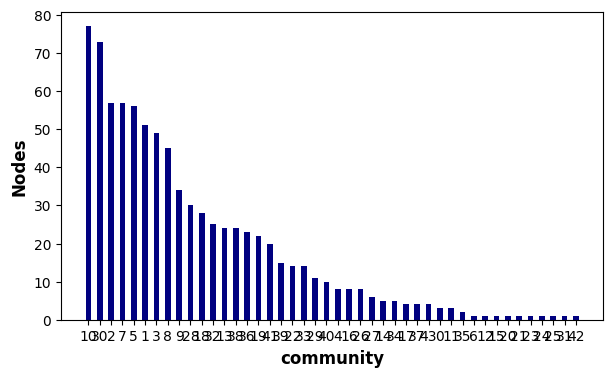

In [12]:
comm_sizes = [(comm, len(nodes)) for comm, nodes in communities.items()]
comm_sizes.sort(key = lambda x: x[1],reverse = True)

plt.figure(figsize = (7,4))
plt.bar(range(len(comm_sizes)), [x[1] for x in comm_sizes],width = 0.5, color = 'navy')
plt.xticks(range(len(comm_sizes)), [x[0] for x in comm_sizes])
plt.xlabel('community',size = 12, weight = 'bold')
plt.ylabel('Nodes',size = 12, weight = 'bold')
plt.show()

In [14]:
coverage, performance = nx_comm.partition_quality(
    G_people,
    communities.values()
)

print(f"Coverage: {coverage}")
print(f"Performance: {performance}")

Coverage: 0.948069241011984
Performance: 0.95588946580188


In [22]:
nx.set_node_attributes(G_people, communities_louvain, 'community')

In [23]:
nx.write_gexf(G_people, "../data/crime/G_people.gexf")

![Graph Image](../data/crime/CrimeGraph.png)